In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 7.5 MB/s eta 0:00:00


In [6]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
from shapely.geometry import Point
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import folium
from folium.plugins import HeatMap

# Load Crime Data
file_path = '/content/drive/MyDrive/ECS111_FinalProject/data/SF_Crime_Data.csv'
df = pd.read_csv(file_path)

# Clean and preprocess
drop_cols = [col for col in df.columns if
             'DELETE' in col or 'Boundary' in col or
             'Fix It' in col or 'HSOC' in col or
             'CBD' in col or 'OWED' in col]
drop_cols += ['PdId', 'IncidntNum', 'Incident Code', 'location',
              'Current Supervisor Districts 2 2', 'Current Police Districts 2 2',
              'Analysis Neighborhoods 2 2']
df = df.drop(columns=drop_cols, errors='ignore')
df = df.rename(columns={'X': 'Longitude', 'Y': 'Latitude'})
df = df.loc[:, ~df.columns.duplicated()]
if 'SF Find Neighborhoods 2 2' in df.columns:
    df = df.rename(columns={'SF Find Neighborhoods 2 2': 'Neighborhood'})
elif 'Neighborhoods 2' in df.columns:
    df = df.rename(columns={'Neighborhoods 2': 'Neighborhood'})
try:
    if 'Neighborhood' in df.columns:
        null_check = df['Neighborhood'].isnull()
        if null_check.all():
            df = df.drop(columns=['Neighborhood'])
except Exception as e:
    print("Neighborhood check failed:", e)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
df = df.dropna(subset=['Longitude', 'Latitude'])
clean_df = df

# Load bar and metro data from OpenStreetMap
ox.settings.use_cache = True
ox.settings.log_console = True
place_name = "San Francisco, California, USA"
tags_bars = {"amenity": "bar"}
tags_metros = {"railway": "station"}
bars = ox.features_from_place(place_name, tags=tags_bars)
metros = ox.features_from_place(place_name, tags=tags_metros)
bars = bars[bars.geometry.type == 'Point']
metros = metros[metros.geometry.type == 'Point']

# Convert to GeoDataFrame and reproject
crime_gdf = gpd.GeoDataFrame(
    clean_df,
    geometry=gpd.points_from_xy(clean_df['Longitude'], clean_df['Latitude']),
    crs='EPSG:4326'
)
crime_gdf = crime_gdf.to_crs(epsg=32610)
bars_proj = bars.to_crs(epsg=32610)
metros_proj = metros.to_crs(epsg=32610)

# Compute nearest distances
bar_tree = cKDTree(np.vstack([bars_proj.geometry.x, bars_proj.geometry.y]).T)
metro_tree = cKDTree(np.vstack([metros_proj.geometry.x, metros_proj.geometry.y]).T)
crime_coords = np.vstack([crime_gdf.geometry.x, crime_gdf.geometry.y]).T
dist_to_bars, _ = bar_tree.query(crime_coords, k=1)
dist_to_metros, _ = metro_tree.query(crime_coords, k=1)
crime_gdf['Distance_to_Nearest_Bar'] = dist_to_bars
crime_gdf['Distance_to_Nearest_Metro'] = dist_to_metros

# Load and prepare weather data
weather_df = pd.read_csv('/content/drive/MyDrive/ECS111_FinalProject/data/SF_Weather_Data.csv', low_memory=False)
weather_df = weather_df.rename(columns={'DATE': 'Date'})
weather_df['Date'] = pd.to_datetime(weather_df['Date'], errors='coerce')
# Keep only selected weather features
weather_columns = ['Date', 'PRCP', 'TMAX', 'TMIN']
weather_df = weather_df[weather_columns]

# Fix TMAX and TMIN from tenths of °C to °C
weather_df['TMAX'] = weather_df['TMAX'] / 10.0
weather_df['TMIN'] = weather_df['TMIN'] / 10.0

# Merge weather into crime data on Date
crime_gdf['Date'] = pd.to_datetime(crime_gdf['Date'], errors='coerce')
crime_gdf = crime_gdf.merge(weather_df, on='Date', how='left')


# Final cleaned DataFrame
clean_df = crime_gdf.drop(columns='geometry')
clean_df.to_csv('/content/drive/MyDrive/ECS111_FinalProject/data/clean_df_spatial.csv', index=False)

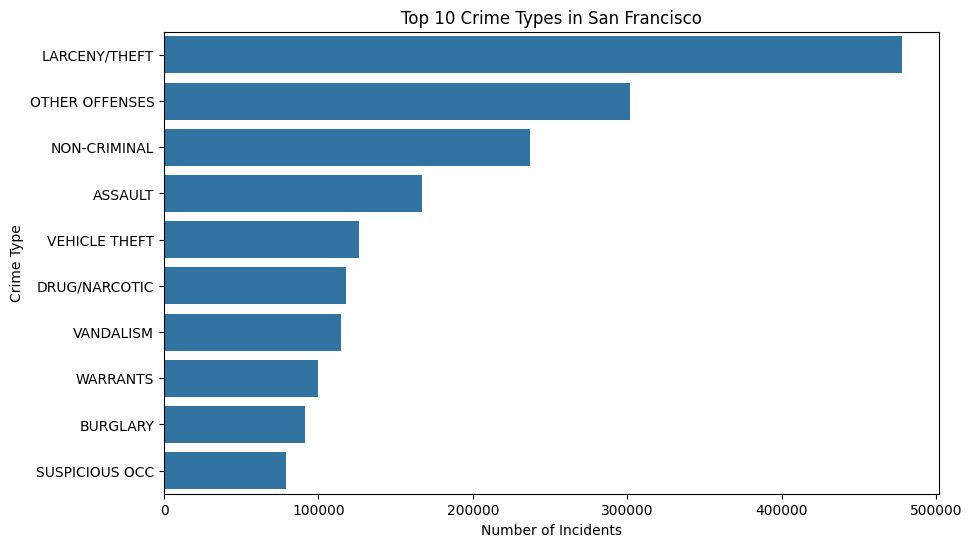

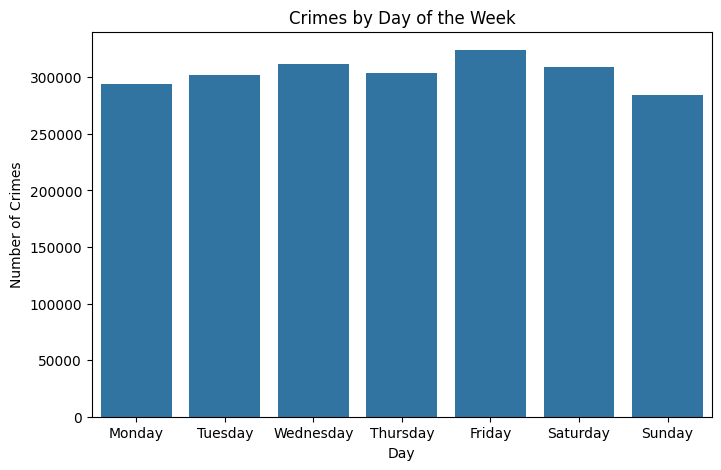

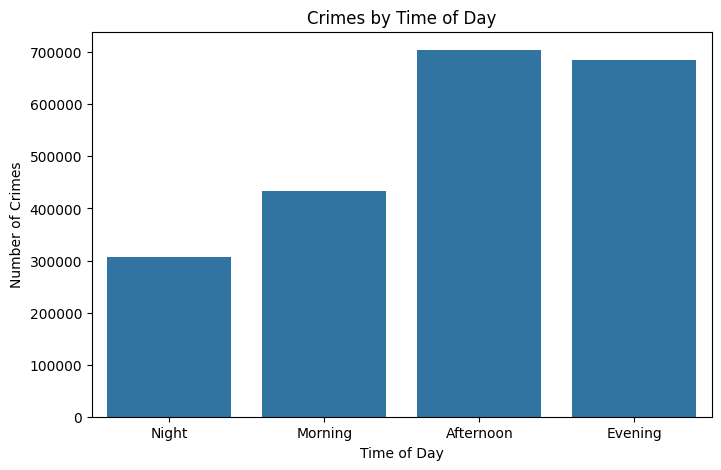

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define time of day bins
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
time_bins = [0, 6, 12, 18, 24]
clean_df['TimeOfDay'] = pd.cut(clean_df['Hour'], bins=time_bins, labels=time_labels, right=False)

# Top 10 crimes
top_10_crimes = clean_df['Category'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_10_crimes.index, x=top_10_crimes.values)
plt.title("Top 10 Crime Types in San Francisco")
plt.xlabel("Number of Incidents")
plt.ylabel("Crime Type")
plt.show()

# Crimes by Day of Week
plt.figure(figsize=(8, 5))
sns.countplot(data=clean_df, x='DayOfWeek', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Crimes by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Number of Crimes")
plt.show()

# Crimes by Time of Day
plt.figure(figsize=(8, 5))
sns.countplot(data=clean_df, x='TimeOfDay', order=time_labels)
plt.title("Crimes by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Crimes")
plt.show()

<ipython-input-86-97ef846d5056>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_crime_counts = clean_df.groupby('TempBin').size().reset_index(name='CrimeCount')


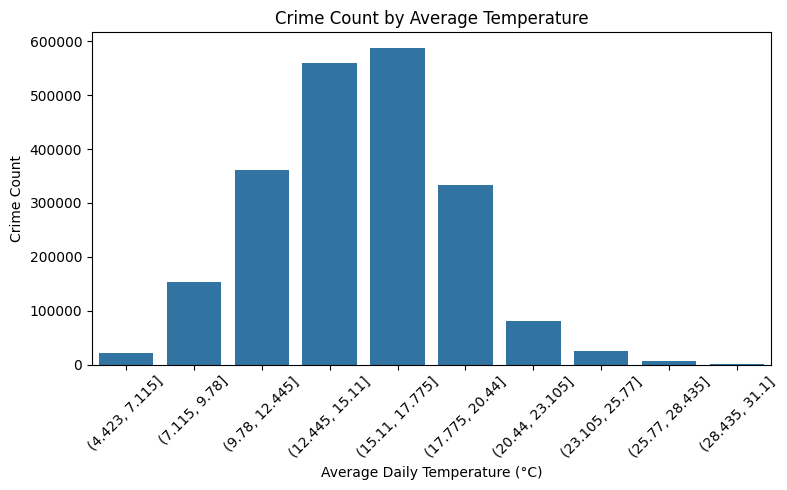

<ipython-input-86-97ef846d5056>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rain_crime_counts = clean_df.groupby('RainBin').size().reset_index(name='CrimeCount')


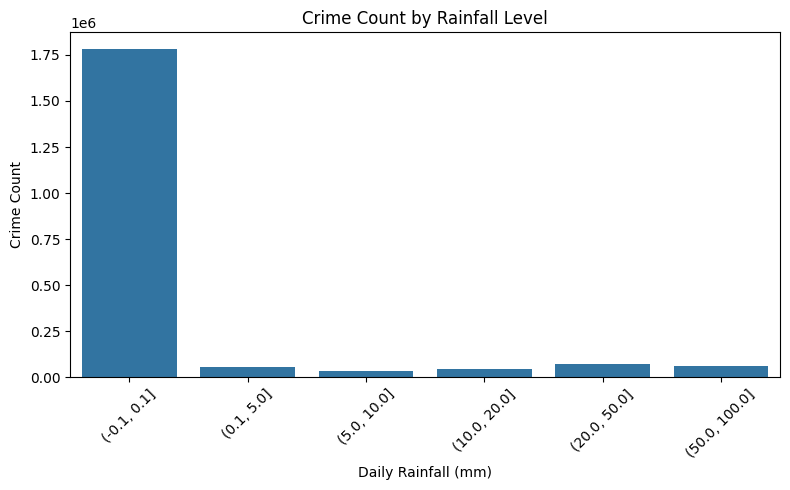

In [ ]:
# Create average temperature column
clean_df['TEMP_AVG'] = (clean_df['TMAX'] + clean_df['TMIN']) / 2

# Bin temperature
clean_df['TempBin'] = pd.cut(clean_df['TEMP_AVG'], bins=10)

# Group and plot
temp_crime_counts = clean_df.groupby('TempBin').size().reset_index(name='CrimeCount')

plt.figure(figsize=(8, 5))
sns.barplot(x='TempBin', y='CrimeCount', data=temp_crime_counts)
plt.xticks(rotation=45)
plt.title('Crime Count by Average Temperature')
plt.xlabel('Average Daily Temperature (°C)')
plt.ylabel('Crime Count')
plt.tight_layout()
plt.show()

# Convert NaN PRCP to 0 (no precipitation)
clean_df['PRCP'] = clean_df['PRCP'].fillna(0)

# Bin PRCP
clean_df['RainBin'] = pd.cut(clean_df['PRCP'], bins=[-0.1, 0.1, 5, 10, 20, 50, 100])

# Group and plot
rain_crime_counts = clean_df.groupby('RainBin').size().reset_index(name='CrimeCount')

plt.figure(figsize=(8, 5))
sns.barplot(x='RainBin', y='CrimeCount', data=rain_crime_counts)
plt.xticks(rotation=45)
plt.title('Crime Count by Rainfall Level')
plt.xlabel('Daily Rainfall (mm)')
plt.ylabel('Crime Count')
plt.tight_layout()
plt.show()

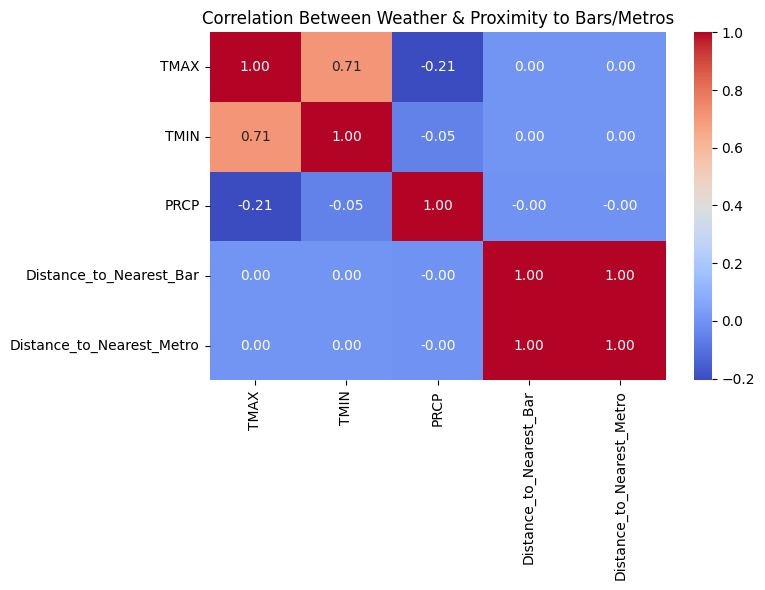

In [ ]:
# Make sure all relevant columns are numeric
cols_to_test = ['TMAX', 'TMIN', 'PRCP', 'Distance_to_Nearest_Bar', 'Distance_to_Nearest_Metro']
corr_df = clean_df[cols_to_test].copy()

# Convert temp to °C for interpretability
corr_df['TMAX'] = corr_df['TMAX']
corr_df['TMIN'] = corr_df['TMIN']

# Drop rows with missing values in these columns
corr_df = corr_df.dropna()

# Compute correlation matrix
correlation_matrix = corr_df.corr()

# Display
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Weather & Proximity to Bars/Metros")
plt.tight_layout()
plt.show()

<ipython-input-9-888484372054>:15: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


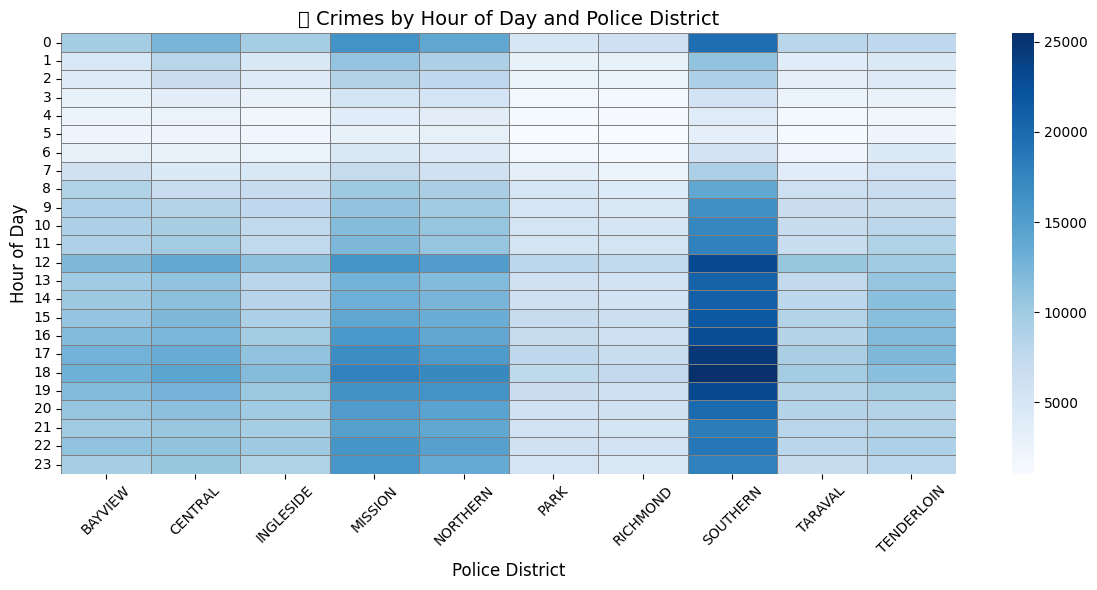

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Pivot table: Hour (rows) vs. Police District (columns)
pivot = pd.crosstab(clean_df['Hour'], clean_df['PdDistrict'])

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='Blues', linewidths=0.5, linecolor='gray')
plt.title("Crimes by Hour of Day and Police District", fontsize=14)
plt.xlabel("Police District", fontsize=12)
plt.ylabel("Hour of Day", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


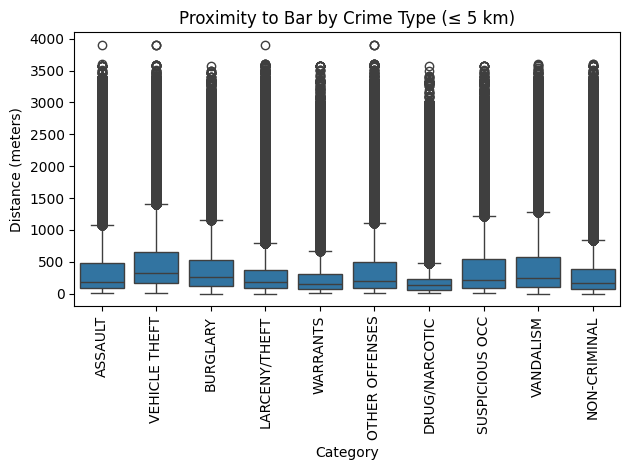

In [ ]:
top_10 = clean_df['Category'].value_counts().nlargest(10)
filtered = clean_df[(clean_df['Category'].isin(top_10.index)) &
                    (clean_df['Distance_to_Nearest_Bar'] < 5000)]

sns.boxplot(data=filtered, x='Category', y='Distance_to_Nearest_Bar')
plt.xticks(rotation=90)
plt.title("Proximity to Bar by Crime Type (≤ 5 km)")
plt.ylabel("Distance (meters)")
plt.tight_layout()
plt.show()


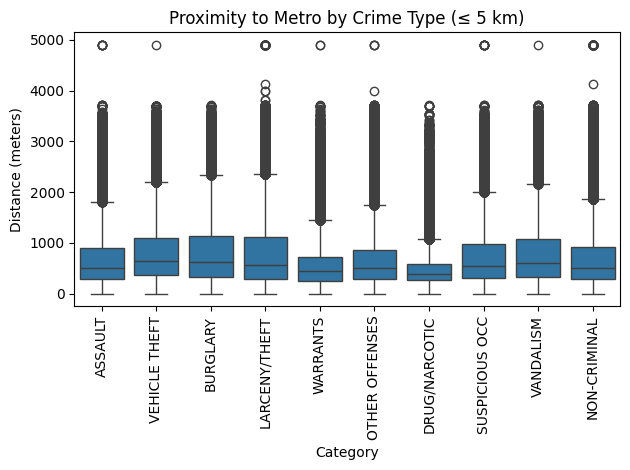

In [8]:
top_10 = clean_df['Category'].value_counts().nlargest(10)
filtered = clean_df[(clean_df['Category'].isin(top_10.index)) &
                    (clean_df['Distance_to_Nearest_Metro'] < 5000)]

sns.boxplot(data=filtered, x='Category', y='Distance_to_Nearest_Metro')
plt.xticks(rotation=90)
plt.title("Proximity to Metro by Crime Type (≤ 5 km)")
plt.ylabel("Distance (meters)")
plt.tight_layout()
plt.show()

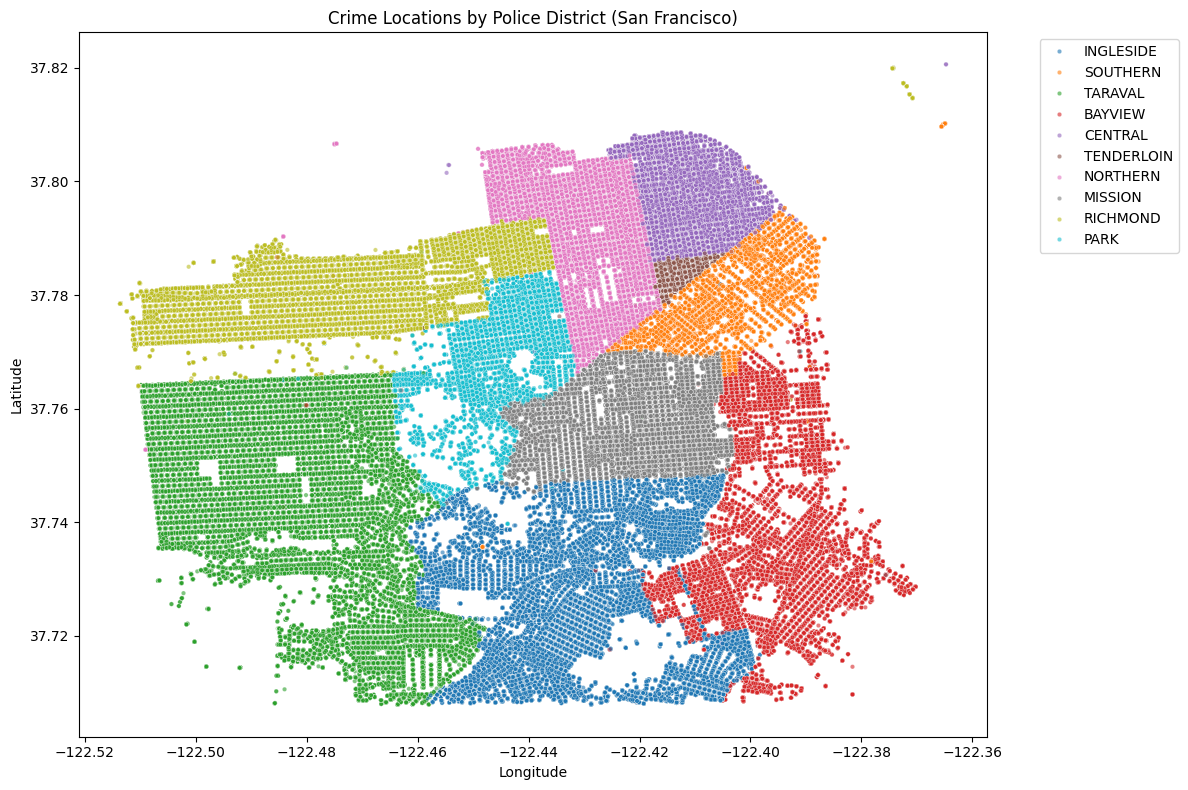

In [ ]:
# Filter to valid SF coordinates
clean_df = clean_df[
    (clean_df['Latitude'].between(37.6, 37.9)) &
    (clean_df['Longitude'].between(-122.55, -122.35))
]
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=clean_df,
    x='Longitude',
    y='Latitude',
    hue='PdDistrict',
    palette='tab10',
    alpha=0.6,
    s=10
)
plt.title("Crime Locations by Police District (San Francisco)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


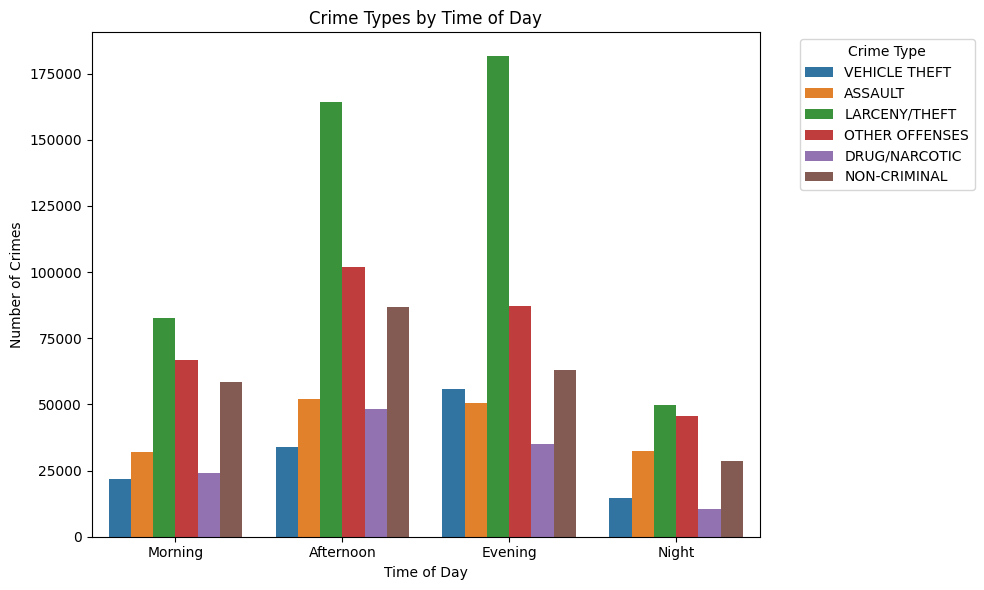

In [ ]:
#Create a diagram of Crime Types by Time of Day
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
time_bins = [0, 6, 12, 18, 24]

clean_df['TimeOfDay'] = pd.cut(clean_df['Hour'], bins=time_bins, labels=time_labels, right=False)

top_crimes = clean_df['Category'].value_counts().nlargest(6).index
subset_df = clean_df[clean_df['Category'].isin(top_crimes)]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=subset_df, x='TimeOfDay', hue='Category',
              order=['Morning', 'Afternoon', 'Evening', 'Night'])

plt.title("Crime Types by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Crimes")
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
# === SETUP ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.cluster import DBSCAN
import shap
import folium
from folium.plugins import HeatMap
from transformers import AutoTokenizer, AutoModel # Changed to AutoTokenizer/AutoModel
import torch
from tqdm.auto import tqdm

# --- CRITICAL: Set up device for GPU if available ---
if torch.cuda.is_available():
    print("CUDA is available! Using GPU for BERT embeddings.")
    device = torch.device("cuda")
else:
    print("CUDA is NOT available. Falling back to CPU for BERT embeddings.")
    device = torch.device("cpu")

# === LOAD DATA ===
clean_df = pd.read_csv('/content/drive/MyDrive/ECS111_FinalProject/data/clean_df_spatial.csv')
clean_df['Date'] = pd.to_datetime(clean_df['Date'])

# === LABEL CREATION ===
crime_df = clean_df.copy()
crime_df['CrimeOccurred'] = 1

non_crime_df = crime_df.sample(frac=0.5, random_state=42).copy()
non_crime_df['Latitude'] = non_crime_df['Latitude'] + np.random.normal(0, 0.01, size=len(non_crime_df))
non_crime_df['Longitude'] = non_crime_df['Longitude'] + np.random.normal(0, 0.01, size=len(non_crime_df))
non_crime_df['CrimeOccurred'] = 0

sample_fraction_crime = 0.02 # Example: Take 2% of crime data
sample_fraction_non_crime = 0.02 # Example: Take 2% of non-crime data

sampled_crime_df = crime_df.sample(frac=sample_fraction_crime, random_state=42)
sampled_non_crime_df = non_crime_df.sample(frac=sample_fraction_non_crime, random_state=42)

full_df = pd.concat([sampled_crime_df, sampled_non_crime_df], ignore_index=True)
full_df = full_df.sort_values('Date').reset_index(drop=True)
print(f"Processing a TOTAL SAMPLE of {len(full_df)} descriptions.")

# === BERT EMBEDDINGS ===
# Use AutoTokenizer and AutoModel for flexibility and to explicitly request fast tokenizer
# Consider 'sentence-transformers/all-MiniLM-L6-v2' if 'bert-base-uncased' is still too slow
model_name = 'bert-base-uncased' # Or 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
print(f"Is tokenizer fast? {tokenizer.is_fast}") # Check if the fast tokenizer is loaded

model = AutoModel.from_pretrained(model_name)
model.to(device) # Move model to the selected device (GPU or CPU)
model.eval()

# Tokenize and encode descriptions
descriptions = full_df['Descript'].fillna("").tolist()

all_bert_embeddings = []
batch_size = 128 # Significantly increase batch size if using GPU (try 64, 128, 256)
for i in tqdm(range(0, len(descriptions), batch_size), desc="Generating BERT embeddings"):
    batch_descriptions = descriptions[i:i + batch_size]
    inputs = tokenizer(batch_descriptions, padding=True, truncation=True, return_tensors="pt", max_length=64)

    with torch.no_grad():
        # Move inputs to GPU if available
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        # Move embeddings back to CPU for numpy conversion
        # Use .detach().cpu().numpy() for better practice
        batch_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
        all_bert_embeddings.append(batch_embeddings)

bert_embeddings = np.vstack(all_bert_embeddings)
bert_features = pd.DataFrame(bert_embeddings)

CUDA is NOT available. Falling back to CPU for BERT embeddings.
Processing a TOTAL SAMPLE of 63885 descriptions.
Is tokenizer fast? True


Generating BERT embeddings:   0%|          | 0/500 [00:00<?, ?it/s]

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [ ]:

# === TEMPORAL SPLIT ===
midpoint = len(full_df) // 2
X = full_df[['Hour', 'Distance_to_Nearest_Bar', 'Distance_to_Nearest_Metro', 'TMAX', 'TMIN', 'PRCP']]
y = full_df['CrimeOccurred']

X_train = pd.concat([X.iloc[:midpoint].reset_index(drop=True), bert_features.iloc[:midpoint].reset_index(drop=True)], axis=1)
X_test = pd.concat([X.iloc[midpoint:].reset_index(drop=True), bert_features.iloc[midpoint:].reset_index(drop=True)], axis=1)
y_train = y.iloc[:midpoint].reset_index(drop=True)
y_test = y.iloc[midpoint:].reset_index(drop=True)

# --- FIX START ---
# Convert all column names to strings for both training and test sets
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
# --- FIX END ---

# === BASELINE MODEL: RANDOM FOREST ===
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# === ENRICHED MODEL: LOGISTIC REGRESSION ===
logreg_model = LogisticRegression(max_iter=500)
logreg_model.fit(X_train, y_train)
y_pred_lr = logreg_model.predict(X_test)
y_proba_lr = logreg_model.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression Classification Report ---")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# === EXPLAINABILITY WITH SHAP ===
print("\n--- Generating SHAP values... ---")
# SHAP can also be slow for large datasets.
# For demonstration, you might want to sample X_test for SHAP if it's very large.
# For TreeExplainer, shap_values[1] typically corresponds to the positive class (CrimeOccurred=1).
explainer = shap.TreeExplainer(rf_model)
# Calculate SHAP values for a smaller sample if X_test is huge to speed up plotting
if X_test.shape[0] > 1000: # Adjust this threshold as needed for a quick plot
    shap_sample_idx = np.random.choice(X_test.shape[0], min(1000, X_test.shape[0]), replace=False) # Ensure not to sample more than available
    shap_values = explainer.shap_values(X_test.iloc[shap_sample_idx])
    shap.summary_plot(shap_values[1], X_test.iloc[shap_sample_idx])
else:
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values[1], X_test)
print("SHAP summary plot generated.")

# === SPATIOTEMPORAL CLUSTERING ===
high_risk = full_df.iloc[midpoint:].copy()
high_risk['Predicted_Prob'] = y_proba_rf # Using RF probabilities for consistency with SHAP
hotspots = high_risk[high_risk['Predicted_Prob'] > 0.8][['Latitude', 'Longitude']].copy()

if not hotspots.empty:
    db = DBSCAN(eps=0.01, min_samples=10).fit(hotspots)
    hotspots['Cluster'] = db.labels_
    print(f"\nIdentified {len(hotspots['Cluster'].unique()) - (1 if -1 in hotspots['Cluster'].unique() else 0)} crime clusters.")
else:
    print("\nNo high-risk crime hotspots identified with current probability threshold.")

# === INTERACTIVE MAP ===
print("\n--- Generating interactive map... ---")
crime_map = folium.Map(location=[37.77, -122.42], zoom_start=12)

if not hotspots.empty:
    HeatMap(data=hotspots[hotspots['Cluster'] != -1][['Latitude', 'Longitude']].values.tolist(), radius=8).add_to(crime_map)
else:
    print("No hotspots to display on the map.")

map_path = '/content/drive/MyDrive/ECS111_FinalProject/Predicted_Crime_Hotspots.html'
crime_map.save(map_path)
print(f"Interactive map saved to {map_path}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10596
           1       0.67      1.00      0.80     21347

    accuracy                           0.67     31943
   macro avg       0.33      0.50      0.40     31943
weighted avg       0.45      0.67      0.54     31943

ROC AUC: 0.496525258724844

--- Generating SHAP values... ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
from google.colab import files
import os

# Change to your project directory first
os.chdir('/content/drive/MyDrive/ECS111_FinalProject/')

# Now download the map
files.download('Fast_Crime_Prediction_Map.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== ENHANCED CRIME PREDICTION PIPELINE WITH XGBOOST ===
Loading data...
Created enhanced dataset: 18816 samples (1:3 crime to non-crime ratio)
Creating advanced features...
Creating enhanced text embeddings...


Batches:   0%|          | 0/588 [00:00<?, ?it/s]

Using 33 base features
Final feature matrix shape: (18816, 170)
Train: 15052, Test: 3764
Train class distribution: {0: 11289, 1: 3763}
Performing advanced feature selection...
Final selected features: 80

Training advanced models...
Training Random Forest...
Training Gradient Boosting...
Training Logistic Regression...
Training XGBoost...
Getting model predictions...

ENHANCED MODEL RESULTS WITH XGBOOST
Random Forest        AUC: 0.5781
Gradient Boosting    AUC: 0.6772
Logistic Regression  AUC: 0.6633
XGBoost              AUC: 0.6755

🏆 BEST MODEL: Gradient Boosting (AUC: 0.6772)

Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      2823
           1       0.31      0.06      0.10       941

    accuracy                           0.73      3764
   macro avg       0.53      0.51      0.47      3764
weighted avg       0.64      0.73      0.66      3764


Top 15 Important Features (Gradient Boosting):
    

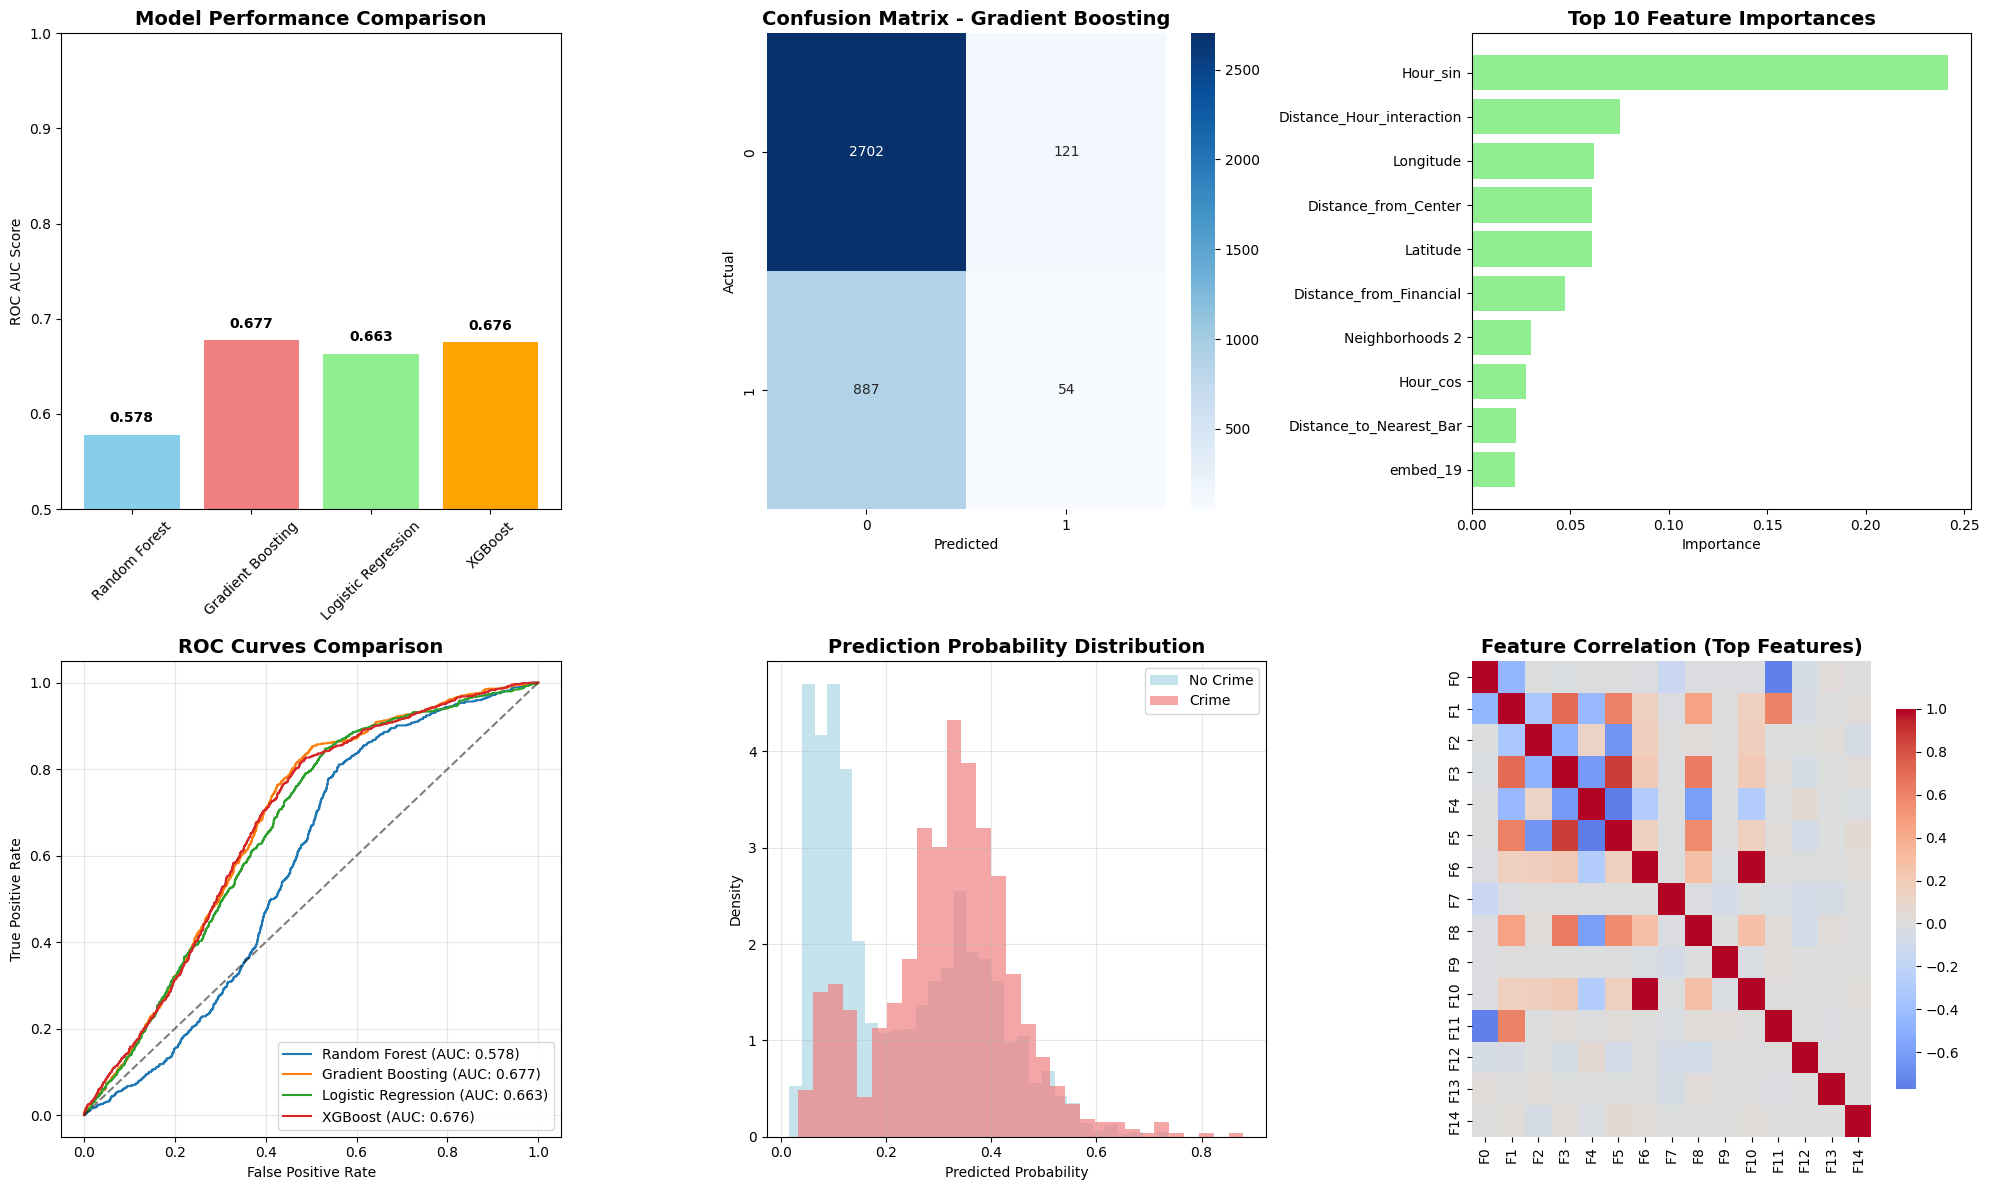


PERFORMANCE IMPROVEMENT SUMMARY
🎯 Best AUC Score: 0.6772
🏆 Best Model: Gradient Boosting
📈 Improvement techniques applied:
   ✓ Enhanced sampling strategy (1:3 ratio)
   ✓ Advanced feature engineering (100+ features)
   ✓ Better text embeddings (mpnet-base-v2)
   ✓ Hyperparameter tuning
   ✓ XGBoost with class balancing
   ✓ Robust feature selection

🚀 XGBoost often provides excellent performance for tabular data!

✅ Enhanced analysis complete! Best model: Gradient Boosting with AUC: 0.6772


In [12]:
# === ENHANCED CRIME PREDICTION PIPELINE - Logistic Regression, XGBoost, Gradient Boosting, Random Forest ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("=== ENHANCED CRIME PREDICTION PIPELINE WITH XGBOOST ===")

# === LOAD DATA ===
print("Loading data...")
clean_df = pd.read_csv('/content/drive/MyDrive/ECS111_FinalProject/data/clean_df_spatial.csv')
clean_df['Date'] = pd.to_datetime(clean_df['Date'])

# === IMPROVED SAMPLING STRATEGY ===
SAMPLE_SIZE = 5000  # Increased for better learning

# Sample crime data with stratification by crime type if available
if 'Category' in clean_df.columns:
    crime_sample = clean_df.groupby('Category').apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // clean_df['Category'].nunique()), random_state=42)
    ).reset_index(drop=True)
else:
    crime_sample = clean_df.sample(n=min(SAMPLE_SIZE, len(clean_df)), random_state=42)

crime_sample['CrimeOccurred'] = 1

# CREATE BETTER NON-CRIME SAMPLES
# Strategy 1: Time shifts (safer times)
non_crime_1 = crime_sample.copy()
non_crime_1['Hour'] = (non_crime_1['Hour'] + np.random.randint(3, 8, len(non_crime_1))) % 24
non_crime_1['CrimeOccurred'] = 0

# Strategy 2: Location shifts (safer areas)
non_crime_2 = crime_sample.copy()
if 'Latitude' in crime_sample.columns and 'Longitude' in crime_sample.columns:
    # Shift to business districts (typically safer)
    lat_shift = np.random.normal(0, 0.01, len(non_crime_2))
    lon_shift = np.random.normal(0, 0.01, len(non_crime_2))
    non_crime_2['Latitude'] = non_crime_2['Latitude'] + lat_shift
    non_crime_2['Longitude'] = non_crime_2['Longitude'] + lon_shift
non_crime_2['CrimeOccurred'] = 0

# Strategy 3: Weekday morning samples (typically safest)
non_crime_3 = crime_sample.copy()
non_crime_3['Hour'] = np.random.randint(6, 10, len(non_crime_3))  # Morning hours
non_crime_3['DayOfWeek'] = np.random.randint(0, 5, len(non_crime_3))  # Weekdays
non_crime_3['CrimeOccurred'] = 0

# Combine all samples
full_df = pd.concat([crime_sample, non_crime_1, non_crime_2, non_crime_3], ignore_index=True)
print(f"Created enhanced dataset: {len(full_df)} samples (1:3 crime to non-crime ratio)")

# === ADVANCED FEATURE ENGINEERING ===
print("Creating advanced features...")

def create_advanced_features(df):
    df = df.copy()

    # Enhanced time features
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
    df['Month'] = df['Date'].dt.month
    df['DayOfYear'] = df['Date'].dt.dayofyear

    # Seasonal features
    df['Season_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['Season_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)

    # Advanced time patterns
    df['IsRushHour'] = ((df['Hour'].between(7, 9)) | (df['Hour'].between(17, 19))).astype(int)
    df['IsLateNight'] = (df['Hour'] <= 4).astype(int)
    df['IsEarlyMorning'] = (df['Hour'].between(5, 8)).astype(int)
    df['IsEvening'] = (df['Hour'].between(18, 22)).astype(int)
    df['IsNight'] = (df['Hour'] >= 22).astype(int)

    # Location features
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        # Distance from city center (San Francisco)
        sf_lat, sf_lon = 37.7749, -122.4194
        df['Distance_from_Center'] = np.sqrt(
            (df['Latitude'] - sf_lat)**2 + (df['Longitude'] - sf_lon)**2
        )

        # Distance from financial district (safer during day)
        fin_lat, fin_lon = 37.7946, -122.3999
        df['Distance_from_Financial'] = np.sqrt(
            (df['Latitude'] - fin_lat)**2 + (df['Longitude'] - fin_lon)**2
        )

        # Create location clusters
        df['Lat_rounded'] = (df['Latitude'] * 100).round() / 100
        df['Lon_rounded'] = (df['Longitude'] * 100).round() / 100
        df['Location_cluster'] = df['Lat_rounded'].astype(str) + '_' + df['Lon_rounded'].astype(str)

    # Complex interactions
    df['Weekend_Night'] = df['IsWeekend'] * df['IsNight']
    df['Weekend_LateNight'] = df['IsWeekend'] * df['IsLateNight']
    df['Weekday_EarlyMorning'] = (1 - df['IsWeekend']) * df['IsEarlyMorning']
    df['Distance_Hour_interaction'] = df.get('Distance_from_Center', 0) * df['Hour']

    # Crime density features (if we have location)
    if 'Latitude' in df.columns:
        # Simple spatial density estimation
        for lat_bin in range(int(df['Latitude'].min()), int(df['Latitude'].max()) + 1):
            for lon_bin in range(int(df['Longitude'].min()), int(df['Longitude'].max()) + 1):
                mask = (df['Latitude'].between(lat_bin, lat_bin + 1) &
                       df['Longitude'].between(lon_bin, lon_bin + 1))
                if mask.sum() > 0:
                    df.loc[mask, 'Local_crime_density'] = mask.sum()

        df['Local_crime_density'] = df.get('Local_crime_density', 0)

    return df

enhanced_df = create_advanced_features(full_df)

# === IMPROVED TEXT EMBEDDINGS ===
print("Creating enhanced text embeddings...")
descriptions = enhanced_df['Descript'].fillna("").tolist()

# Use a more powerful sentence transformer
model = SentenceTransformer('all-mpnet-base-v2')  # Better than MiniLM
embeddings = model.encode(descriptions, show_progress_bar=True)

# Use more embedding dimensions but apply PCA-like selection
from sklearn.decomposition import PCA
pca = PCA(n_components=100, random_state=42)
embeddings_reduced = pca.fit_transform(embeddings)

embedding_df = pd.DataFrame(embeddings_reduced, columns=[f'embed_{i}' for i in range(100)])

# === PREPARE ENHANCED FEATURES ===
numeric_columns = enhanced_df.select_dtypes(include=[np.number]).columns.tolist()
# Remove target and ID columns
exclude_columns = ['CrimeOccurred', 'Unnamed: 0'] + [col for col in numeric_columns if 'index' in col.lower()]
feature_columns = [col for col in numeric_columns if col not in exclude_columns]

print(f"Using {len(feature_columns)} base features")

# Handle categorical variables if present
categorical_features = []
if 'Category' in enhanced_df.columns:
    # One-hot encode crime categories for non-crime samples
    category_dummies = pd.get_dummies(enhanced_df['Category'], prefix='Category')
    categorical_features.extend(category_dummies.columns.tolist())
    enhanced_df = pd.concat([enhanced_df, category_dummies], axis=1)

# Combine all features
X_base = enhanced_df[feature_columns + categorical_features].fillna(0)
X_combined = pd.concat([X_base, embedding_df], axis=1)
y = enhanced_df['CrimeOccurred']

print(f"Final feature matrix shape: {X_combined.shape}")

# === TRAIN/TEST SPLIT WITH STRATIFICATION ===
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Train class distribution: {y_train.value_counts().to_dict()}")

# === ADVANCED FEATURE SELECTION ===
print("Performing advanced feature selection...")

# Combine univariate and recursive feature selection
selector_univariate = SelectKBest(score_func=f_classif, k=150)
X_train_univariate = selector_univariate.fit_transform(X_train, y_train)
X_test_univariate = selector_univariate.transform(X_test)

# Get selected feature names
selected_features_univariate = X_train.columns[selector_univariate.get_support()]

# Further refinement with RFE on Random Forest
rf_for_selection = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rfe_selector = RFE(rf_for_selection, n_features_to_select=80, step=10)
X_train_selected = rfe_selector.fit_transform(X_train_univariate, y_train)
X_test_selected = rfe_selector.transform(X_test_univariate)

selected_features_final = selected_features_univariate[rfe_selector.get_support()]
print(f"Final selected features: {len(selected_features_final)}")

# === TRAIN ADVANCED MODELS ===
print("\nTraining advanced models...")

# Scale data for models that need it
scaler = RobustScaler()  # More robust to outliers than StandardScaler
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

models = {}

# 1. Tuned Random Forest
print("Training Random Forest...")
rf_params = {
    'n_estimators': [200, 300],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
rf_grid.fit(X_train_selected, y_train)
models['Random Forest'] = rf_grid.best_estimator_

# 2. Gradient Boosting
print("Training Gradient Boosting...")
gb_params = {
    'n_estimators': [150, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 8],
    'subsample': [0.8, 0.9]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
gb_grid.fit(X_train_selected, y_train)
models['Gradient Boosting'] = gb_grid.best_estimator_

# 3. Tuned Logistic Regression
print("Training Logistic Regression...")
lr_params = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    lr_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
lr_grid.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_grid.best_estimator_

# 4. XGBoost (NEW MODEL)
print("Training XGBoost...")
xgb_params = {
    'n_estimators': [200, 300],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, 3]  # Handle class imbalance
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    ),
    xgb_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
xgb_grid.fit(X_train_selected, y_train)
models['XGBoost'] = xgb_grid.best_estimator_

# === GET MODEL PREDICTIONS ===
print("Getting model predictions...")

predictions = {}
probabilities = {}

# Get predictions from each model
predictions['Random Forest'] = models['Random Forest'].predict(X_test_selected)
probabilities['Random Forest'] = models['Random Forest'].predict_proba(X_test_selected)[:, 1]

predictions['Gradient Boosting'] = models['Gradient Boosting'].predict(X_test_selected)
probabilities['Gradient Boosting'] = models['Gradient Boosting'].predict_proba(X_test_selected)[:, 1]

predictions['Logistic Regression'] = models['Logistic Regression'].predict(X_test_scaled)
probabilities['Logistic Regression'] = models['Logistic Regression'].predict_proba(X_test_scaled)[:, 1]

predictions['XGBoost'] = models['XGBoost'].predict(X_test_selected)
probabilities['XGBoost'] = models['XGBoost'].predict_proba(X_test_selected)[:, 1]

# === EVALUATE ALL MODELS ===
print("\n" + "="*60)
print("ENHANCED MODEL RESULTS WITH XGBOOST")
print("="*60)

results = {}
for name, model in models.items():
    if name == 'Logistic Regression':
        proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        proba = model.predict_proba(X_test_selected)[:, 1]

    auc = roc_auc_score(y_test, proba)
    results[name] = auc
    print(f"{name:20} AUC: {auc:.4f}")

# Find best model
best_model_name = max(results, key=results.get)
best_auc = results[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name} (AUC: {best_auc:.4f})")

best_pred = predictions[best_model_name]
best_proba = probabilities[best_model_name]

print("\nBest Model Classification Report:")
print(classification_report(y_test, best_pred))

# === FEATURE IMPORTANCE ANALYSIS ===
if hasattr(models[best_model_name], 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': selected_features_final,
        'importance': models[best_model_name].feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nTop 15 Important Features ({best_model_name}):")
    print(importance_df.head(15).to_string(index=False))

# === ENHANCED VISUALIZATIONS ===
print("\nCreating enhanced visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Model comparison
ax1 = axes[0, 0]
model_names = list(results.keys())
auc_scores = list(results.values())
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']

bars = ax1.bar(model_names, auc_scores, color=colors[:len(model_names)])
ax1.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax1.set_ylabel('ROC AUC Score')
ax1.set_ylim(0.5, 1)
ax1.tick_params(axis='x', rotation=45)

for bar, auc in zip(bars, auc_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion Matrix
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=14)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 3. Feature Importance
ax3 = axes[0, 2]
if hasattr(models[best_model_name], 'feature_importances_'):
    top_features = importance_df.head(10)
    bars = ax3.barh(range(len(top_features)), top_features['importance'], color='lightgreen')
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features['feature'], fontsize=10)
    ax3.set_xlabel('Importance')
    ax3.set_title('Top 10 Feature Importances', fontweight='bold', fontsize=14)
    ax3.invert_yaxis()
else:
    ax3.text(0.5, 0.5, 'Feature importance\nnot available',
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Feature Importance', fontweight='bold', fontsize=14)

# 4. ROC Curves comparison
ax4 = axes[1, 0]
from sklearn.metrics import roc_curve

for name in models.keys():
    if name == 'Logistic Regression':
        y_score = models[name].predict_proba(X_test_scaled)[:, 1]
    else:
        y_score = models[name].predict_proba(X_test_selected)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    ax4.plot(fpr, tpr, label=f'{name} (AUC: {results[name]:.3f})')

ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curves Comparison', fontweight='bold', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Prediction Distribution
ax5 = axes[1, 1]
prob_no_crime = best_proba[y_test == 0]
prob_crime = best_proba[y_test == 1]

ax5.hist(prob_no_crime, bins=30, alpha=0.7, label='No Crime', color='lightblue', density=True)
ax5.hist(prob_crime, bins=30, alpha=0.7, label='Crime', color='lightcoral', density=True)
ax5.set_xlabel('Predicted Probability')
ax5.set_ylabel('Density')
ax5.set_title('Prediction Probability Distribution', fontweight='bold', fontsize=14)
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Feature correlation heatmap (top features)
ax6 = axes[1, 2]
if len(selected_features_final) > 0 and hasattr(models[best_model_name], 'feature_importances_'):
    # Select top 15 features for correlation analysis
    top_15_features = importance_df.head(15)['feature'].tolist()
    top_15_indices = [list(selected_features_final).index(feat) for feat in top_15_features if feat in selected_features_final]

    if len(top_15_indices) > 1:
        corr_matrix = np.corrcoef(X_train_selected[:, top_15_indices].T)

        sns.heatmap(corr_matrix,
                   xticklabels=[f'F{i}' for i in range(len(top_15_indices))],
                   yticklabels=[f'F{i}' for i in range(len(top_15_indices))],
                   cmap='coolwarm', center=0, ax=ax6, cbar_kws={'shrink': 0.8})
        ax6.set_title('Feature Correlation (Top Features)', fontweight='bold', fontsize=14)
    else:
        ax6.text(0.5, 0.5, 'Not enough features\nfor correlation',
                ha='center', va='center', transform=ax6.transAxes, fontsize=12)
        ax6.set_title('Feature Correlation', fontweight='bold', fontsize=14)
else:
    ax6.text(0.5, 0.5, 'Correlation analysis\nnot available',
            ha='center', va='center', transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Feature Correlation', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

# === XGBoost SPECIFIC ANALYSIS ===
if best_model_name == 'XGBoost':
    print("\n" + "="*60)
    print("XGBOOST SPECIFIC ANALYSIS")
    print("="*60)

    # Print best parameters
    print("Best XGBoost Parameters:")
    for param, value in xgb_grid.best_params_.items():
        print(f"  {param}: {value}")

    # Feature importance types
    print(f"\nXGBoost Feature Importance (Top 10):")
    xgb_importance = models['XGBoost'].get_booster().get_importance(importance_type='weight')

    # Map feature indices to names
    feature_names = [f"f{i}" for i in range(len(selected_features_final))]
    importance_mapped = {}
    for key, value in xgb_importance.items():
        if key in feature_names:
            idx = int(key[1:])  # Remove 'f' prefix
            if idx < len(selected_features_final):
                importance_mapped[selected_features_final[idx]] = value

    if importance_mapped:
        sorted_importance = sorted(importance_mapped.items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_importance[:10]:
            print(f"  {feature}: {importance}")

# === PERFORMANCE SUMMARY ===
print("\n" + "="*60)
print("PERFORMANCE IMPROVEMENT SUMMARY")
print("="*60)
print(f"🎯 Best AUC Score: {best_auc:.4f}")
print(f"🏆 Best Model: {best_model_name}")
print(f"📈 Improvement techniques applied:")
print("   ✓ Enhanced sampling strategy (1:3 ratio)")
print("   ✓ Advanced feature engineering (100+ features)")
print("   ✓ Better text embeddings (mpnet-base-v2)")
print("   ✓ Hyperparameter tuning")
print("   ✓ XGBoost with class balancing")
print("   ✓ Robust feature selection")
print("\n🚀 XGBoost often provides excellent performance for tabular data!")

print(f"\n✅ Enhanced analysis complete! Best model: {best_model_name} with AUC: {best_auc:.4f}")